In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
from tensorflow import keras

# the nightly build of tensorflow_probability is required as of the time of writing this 
import tensorflow_probability as tfp
ds = tfp.distributions

C:\Users\liuzhehao\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from sklearn.datasets import load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle as pkl
from pandas.api.types import is_numeric_dtype

In [4]:
with open('D:/za-xiaoying-update/data/processed/data_0814.pkl', 'rb') as f:
    X_train, y_train, _, _  = pkl.load(f)
    
with open('D:/za-xiaoying-update/data/processed/useful_features.txt', 'r') as f:
    feature_cols = [i.strip() for i in f.readlines()]
    
feature_cols = [c for c in feature_cols if is_numeric_dtype(X_train[c])][:100] 

for _ in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X_train[feature_cols], y_train, stratify=y_train, train_size=0.7)
    
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

C:\Users\liuzhehao\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\liuzhehao\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\liuzhehao\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
def standardize(x):
    mean_, var_ = tf.nn.moments(x, axes=[0], keepdims=True)
    return (x - mean_) / tf.sqrt(var_)

In [6]:
N_FEATURE = X_train.shape[1]
BATCH_SIZE = 2048

train_dataset = tf.data.Dataset.from_tensor_slices(X_train.values.astype('float32')) \
    .shuffle(10000).batch(BATCH_SIZE).map(standardize)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test.values.astype('float32')) \
    .shuffle(10000).batch(10000).map(standardize)

In [7]:
sample = next(iter(train_dataset))

In [8]:
def make_encoder_decoder(hidden_size=8, share_hidden=False):
    if share_hidden is False:
        hidden_size = hidden_size * 2
        
    encoder = tf.keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(N_FEATURE,)),
        keras.layers.Dense(64, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(32, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(hidden_size)
    ])

    decoder = tf.keras.models.Sequential([
        keras.layers.Dense(32, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(64, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(N_FEATURE)
    ])
    
    return encoder, decoder

In [9]:
def check_gradients(gradients):
    grad = [i.numpy() for i in gradients]
    if all([np.isfinite(g).all() for g in grad]):
        avg_grad = [np.mean(g) for g in grad]
        mean_, std_ = np.mean(avg_grad), np.std(avg_grad)
        print('Gradients stats: mean={}, std={}'.format(mean_, std_))
    else:
        print('Gradient exploded: {}'.format(grad))

In [11]:
class VAE(tf.keras.Model):
    
    def __init__(self, optimizer, hidden_size=8, share_hidden=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.share_hidden = share_hidden
        self.encoder, self.decoder = make_encoder_decoder(hidden_size, share_hidden)
        
        # only used when share hidden is False
        self.dense_mean = keras.layers.Dense(hidden_size)
        self.dense_std = keras.layers.Dense(hidden_size)
        
        self.optimizer = optimizer
    
    def encode(self, x):
        encoded = self.encoder(x)
        if self.share_hidden:
            mu, sigma = self.dense_mean(encoded), self.dense_std(encoded)
        else:
            mu, sigma = tf.split(encoded, num_or_size_splits=2, axis=1)
        return mu, sigma, ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

    def decode(self, z):
        return self.decoder(z)
    
    def compute_loss(self, x):
        mu, sigma, q_z = self.encode(x)
        z = sigma * q_z.sample() + mu
        x_recon = self.decode(z)
        
        # standard normal distribution
        p_z = ds.MultivariateNormalDiag(loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1])
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0))
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_recon), axis=0))
        return latent_loss, recon_loss
    
    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            latent_loss, recon_loss = self.compute_loss(x)
            loss = (latent_loss + recon_loss) / 2
        gradients = tape.gradient(loss, self.trainable_variables)
#         return gradients
        grad = [g.numpy() for g in gradients]
        if all([np.isfinite(g).all() for g in grad]):
            return gradients
        else:
            print('Gradient exploded.')
            return None
        
#     @tf.function
    def train(self, train_x):
        gradients = self.compute_gradients(train_x)
        if gradients is not None:
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

In [32]:
n_epochs = 2000
N_TRAIN_BATCHES = X_train.shape[0] // BATCH_SIZE
N_TEST_BATCHES = X_test.shape[0] // BATCH_SIZE

losses = pd.DataFrame(columns = ['recon_loss', 'latent_loss'])

model = VAE(keras.optimizers.Adam(1e-3), hidden_size=4, share_hidden=False)
for epoch in tqdm(range(n_epochs), total=n_epochs):
    # train
    for batch, train_x in zip(range(N_TRAIN_BATCHES), train_dataset):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in zip(range(N_TEST_BATCHES), test_dataset):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    
    print(
        "Epoch: {} | recon_loss: {} | latent_loss: {}".format(
           epoch, losses.recon_loss.values[-1], losses.latent_loss.values[-1]
        )
    )

Epoch: 0 | recon_loss: 5.166403293609619 | latent_loss: 2033.228515625
Epoch: 1 | recon_loss: 5.289287567138672 | latent_loss: 1971.721435546875
Epoch: 2 | recon_loss: 5.546452045440674 | latent_loss: 1888.593505859375
Epoch: 3 | recon_loss: 6.080455780029297 | latent_loss: 1815.753662109375
Epoch: 4 | recon_loss: 6.619747638702393 | latent_loss: 1752.0726318359375
Epoch: 5 | recon_loss: 7.342693328857422 | latent_loss: 1700.341552734375
Epoch: 6 | recon_loss: 7.913060188293457 | latent_loss: 1659.6826171875
Epoch: 7 | recon_loss: 8.467793464660645 | latent_loss: 1636.4580078125
Epoch: 8 | recon_loss: 8.586648941040039 | latent_loss: 1619.791748046875
Epoch: 9 | recon_loss: 9.042457580566406 | latent_loss: 1597.695556640625
Epoch: 10 | recon_loss: 9.570672988891602 | latent_loss: 1576.854736328125
Epoch: 11 | recon_loss: 9.91971206665039 | latent_loss: 1552.548828125
Epoch: 12 | recon_loss: 10.23808479309082 | latent_loss: 1537.57666015625
Epoch: 13 | recon_loss: 9.902434349060059 | la

Epoch: 109 | recon_loss: 14.776297569274902 | latent_loss: 1165.26416015625
Epoch: 110 | recon_loss: 14.645112037658691 | latent_loss: 1163.5361328125
Epoch: 111 | recon_loss: 15.20779800415039 | latent_loss: 1176.0753173828125
Epoch: 112 | recon_loss: 14.227375984191895 | latent_loss: 1328.2293701171875
Epoch: 113 | recon_loss: 13.617915153503418 | latent_loss: 1274.9130859375
Epoch: 114 | recon_loss: 13.529020309448242 | latent_loss: 1230.9449462890625
Epoch: 115 | recon_loss: 14.148139953613281 | latent_loss: 1203.262451171875
Epoch: 116 | recon_loss: 14.330560684204102 | latent_loss: 1186.3944091796875
Epoch: 117 | recon_loss: 14.309005737304688 | latent_loss: 1179.2052001953125
Epoch: 118 | recon_loss: 14.541938781738281 | latent_loss: 1175.999267578125
Epoch: 119 | recon_loss: 14.798362731933594 | latent_loss: 1181.603271484375
Epoch: 120 | recon_loss: 15.090551376342773 | latent_loss: 1179.767822265625
Epoch: 121 | recon_loss: 15.0759916305542 | latent_loss: 1172.0330810546875
E

Epoch: 215 | recon_loss: 12.967464447021484 | latent_loss: 1097.785888671875
Epoch: 216 | recon_loss: 13.381345748901367 | latent_loss: 1094.312744140625
Epoch: 217 | recon_loss: 13.438560485839844 | latent_loss: 1092.6298828125
Epoch: 218 | recon_loss: 13.4871826171875 | latent_loss: 1091.3101806640625
Epoch: 219 | recon_loss: 13.55232048034668 | latent_loss: 1094.271728515625
Epoch: 220 | recon_loss: 13.033183097839355 | latent_loss: 1097.5986328125
Epoch: 221 | recon_loss: 13.09692096710205 | latent_loss: 1093.5654296875
Epoch: 222 | recon_loss: 13.317302703857422 | latent_loss: 1090.870849609375
Epoch: 223 | recon_loss: 13.359305381774902 | latent_loss: 1091.56982421875
Epoch: 224 | recon_loss: 13.30385971069336 | latent_loss: 1095.858642578125
Epoch: 225 | recon_loss: 13.392251968383789 | latent_loss: 1091.881591796875
Epoch: 226 | recon_loss: 13.44400691986084 | latent_loss: 1087.4659423828125
Epoch: 227 | recon_loss: 13.475377082824707 | latent_loss: 1088.808349609375
Epoch: 228

Epoch: 322 | recon_loss: 14.53849983215332 | latent_loss: 1086.20751953125
Epoch: 323 | recon_loss: 14.666227340698242 | latent_loss: 1079.0145263671875
Epoch: 324 | recon_loss: 14.79447078704834 | latent_loss: 1075.8756103515625
Epoch: 325 | recon_loss: 14.892261505126953 | latent_loss: 1072.212158203125
Epoch: 326 | recon_loss: 14.747109413146973 | latent_loss: 1084.84619140625
Epoch: 327 | recon_loss: 13.30976676940918 | latent_loss: 1096.048095703125
Epoch: 328 | recon_loss: 13.208255767822266 | latent_loss: 1085.528564453125
Epoch: 329 | recon_loss: 13.563348770141602 | latent_loss: 1078.151611328125
Epoch: 330 | recon_loss: 13.906776428222656 | latent_loss: 1075.083984375
Epoch: 331 | recon_loss: 13.872005462646484 | latent_loss: 1072.99462890625
Epoch: 332 | recon_loss: 13.99184513092041 | latent_loss: 1069.925537109375
Epoch: 333 | recon_loss: 13.905028343200684 | latent_loss: 1066.846923828125
Epoch: 334 | recon_loss: 13.94522476196289 | latent_loss: 1066.4163818359375
Epoch: 

Epoch: 429 | recon_loss: 13.272171020507812 | latent_loss: 1034.75439453125
Epoch: 430 | recon_loss: 13.073461532592773 | latent_loss: 1056.1663818359375
Epoch: 431 | recon_loss: 13.642776489257812 | latent_loss: 1041.9990234375
Epoch: 432 | recon_loss: 13.645208358764648 | latent_loss: 1038.048583984375
Epoch: 433 | recon_loss: 13.56715202331543 | latent_loss: 1035.81298828125
Epoch: 434 | recon_loss: 13.561033248901367 | latent_loss: 1033.62744140625
Epoch: 435 | recon_loss: 13.362956047058105 | latent_loss: 1033.8350830078125
Epoch: 436 | recon_loss: 13.3604736328125 | latent_loss: 1034.635986328125
Epoch: 437 | recon_loss: 13.470293998718262 | latent_loss: 1033.5438232421875
Epoch: 438 | recon_loss: 13.459558486938477 | latent_loss: 1032.53564453125
Epoch: 439 | recon_loss: 13.405420303344727 | latent_loss: 1031.58984375
Epoch: 440 | recon_loss: 13.357939720153809 | latent_loss: 1031.31884765625
Epoch: 441 | recon_loss: 13.417682647705078 | latent_loss: 1031.593017578125
Epoch: 442

Epoch: 536 | recon_loss: 12.165142059326172 | latent_loss: 1019.9136962890625
Epoch: 537 | recon_loss: 12.028822898864746 | latent_loss: 1021.2688598632812
Epoch: 538 | recon_loss: 11.859959602355957 | latent_loss: 1019.7725830078125
Epoch: 539 | recon_loss: 11.908286094665527 | latent_loss: 1020.1885986328125
Epoch: 540 | recon_loss: 12.056865692138672 | latent_loss: 1020.2332763671875
Epoch: 541 | recon_loss: 12.256260871887207 | latent_loss: 1020.3465576171875
Epoch: 542 | recon_loss: 12.45804214477539 | latent_loss: 1026.31787109375
Epoch: 543 | recon_loss: 12.452250480651855 | latent_loss: 1021.8307495117188
Epoch: 544 | recon_loss: 12.273834228515625 | latent_loss: 1019.2100830078125
Epoch: 545 | recon_loss: 12.125999450683594 | latent_loss: 1019.1536254882812
Epoch: 546 | recon_loss: 12.049164772033691 | latent_loss: 1018.4267578125
Epoch: 547 | recon_loss: 12.259346008300781 | latent_loss: 1025.92236328125
Epoch: 548 | recon_loss: 12.178298950195312 | latent_loss: 1019.19396972

Epoch: 642 | recon_loss: 11.233123779296875 | latent_loss: 1012.908447265625
Epoch: 643 | recon_loss: 11.247621536254883 | latent_loss: 1013.1431884765625
Epoch: 644 | recon_loss: 10.95969009399414 | latent_loss: 1008.8326416015625
Epoch: 645 | recon_loss: 10.91899299621582 | latent_loss: 1007.8660888671875
Epoch: 646 | recon_loss: 11.027587890625 | latent_loss: 1008.8665771484375
Epoch: 647 | recon_loss: 11.28248119354248 | latent_loss: 1033.531005859375
Epoch: 648 | recon_loss: 11.692935943603516 | latent_loss: 1025.6427001953125
Epoch: 649 | recon_loss: 11.807051658630371 | latent_loss: 1034.39697265625
Epoch: 650 | recon_loss: 11.245748519897461 | latent_loss: 1014.8463134765625
Epoch: 651 | recon_loss: 11.172085762023926 | latent_loss: 1010.3271484375
Epoch: 652 | recon_loss: 11.076971054077148 | latent_loss: 1008.79736328125
Epoch: 653 | recon_loss: 11.045530319213867 | latent_loss: 1008.78125
Epoch: 654 | recon_loss: 11.143186569213867 | latent_loss: 1008.313232421875
Epoch: 655

Epoch: 749 | recon_loss: 10.253393173217773 | latent_loss: 1005.7518310546875
Epoch: 750 | recon_loss: 10.646257400512695 | latent_loss: 1007.480224609375
Epoch: 751 | recon_loss: 9.6904878616333 | latent_loss: 1084.44482421875
Epoch: 752 | recon_loss: 9.241270065307617 | latent_loss: 1073.61865234375
Epoch: 753 | recon_loss: 9.53607177734375 | latent_loss: 1034.152099609375
Epoch: 754 | recon_loss: 9.94317626953125 | latent_loss: 1020.27490234375
Epoch: 755 | recon_loss: 10.004705429077148 | latent_loss: 1014.4112548828125
Epoch: 756 | recon_loss: 10.086593627929688 | latent_loss: 1010.6414794921875
Epoch: 757 | recon_loss: 10.943390846252441 | latent_loss: 1011.5426025390625
Epoch: 758 | recon_loss: 10.830188751220703 | latent_loss: 1008.7723388671875
Epoch: 759 | recon_loss: 10.960380554199219 | latent_loss: 1007.1177978515625
Epoch: 760 | recon_loss: 11.062671661376953 | latent_loss: 1003.6627197265625
Epoch: 761 | recon_loss: 10.970020294189453 | latent_loss: 1003.4718017578125
Ep

Epoch: 856 | recon_loss: 10.260440826416016 | latent_loss: 993.74560546875
Epoch: 857 | recon_loss: 10.269094467163086 | latent_loss: 993.447021484375
Epoch: 858 | recon_loss: 10.316962242126465 | latent_loss: 993.8963623046875
Epoch: 859 | recon_loss: 10.42091178894043 | latent_loss: 993.7620849609375
Epoch: 860 | recon_loss: 10.355644226074219 | latent_loss: 993.0321655273438
Epoch: 861 | recon_loss: 10.73270320892334 | latent_loss: 994.1946411132812
Epoch: 862 | recon_loss: 10.576606750488281 | latent_loss: 993.4520263671875
Epoch: 863 | recon_loss: 9.858024597167969 | latent_loss: 1001.752685546875
Epoch: 864 | recon_loss: 8.783367156982422 | latent_loss: 1028.405029296875
Epoch: 865 | recon_loss: 8.902215957641602 | latent_loss: 1016.495361328125
Epoch: 866 | recon_loss: 9.239326477050781 | latent_loss: 1009.015869140625
Epoch: 867 | recon_loss: 9.481771469116211 | latent_loss: 1004.264404296875
Epoch: 868 | recon_loss: 9.589493751525879 | latent_loss: 1000.72802734375
Epoch: 869 

Epoch: 964 | recon_loss: 9.757996559143066 | latent_loss: 985.602294921875
Epoch: 965 | recon_loss: 9.863329887390137 | latent_loss: 984.86181640625
Epoch: 966 | recon_loss: 9.691587448120117 | latent_loss: 987.671630859375
Epoch: 967 | recon_loss: 9.603825569152832 | latent_loss: 990.6824340820312
Epoch: 968 | recon_loss: 9.609699249267578 | latent_loss: 987.468505859375
Epoch: 969 | recon_loss: 9.78615951538086 | latent_loss: 984.7763671875
Epoch: 970 | recon_loss: 9.785741806030273 | latent_loss: 985.0858154296875
Epoch: 971 | recon_loss: 9.789604187011719 | latent_loss: 985.4375610351562
Epoch: 972 | recon_loss: 9.83220100402832 | latent_loss: 984.46435546875
Epoch: 973 | recon_loss: 9.668670654296875 | latent_loss: 986.4962158203125
Epoch: 974 | recon_loss: 9.808855056762695 | latent_loss: 985.6285400390625
Epoch: 975 | recon_loss: 9.848071098327637 | latent_loss: 984.706298828125
Epoch: 976 | recon_loss: 9.82011604309082 | latent_loss: 984.3250732421875
Epoch: 977 | recon_loss: 1

Epoch: 1072 | recon_loss: 9.860551834106445 | latent_loss: 985.6373291015625
Epoch: 1073 | recon_loss: 9.58176040649414 | latent_loss: 980.037353515625
Epoch: 1074 | recon_loss: 9.596502304077148 | latent_loss: 977.672607421875
Epoch: 1075 | recon_loss: 9.507637023925781 | latent_loss: 978.6322021484375
Epoch: 1076 | recon_loss: 9.545736312866211 | latent_loss: 977.6890258789062
Epoch: 1077 | recon_loss: 9.538010597229004 | latent_loss: 992.3284301757812
Epoch: 1078 | recon_loss: 9.437177658081055 | latent_loss: 982.9830932617188
Epoch: 1079 | recon_loss: 9.641984939575195 | latent_loss: 978.2835693359375
Epoch: 1080 | recon_loss: 9.571571350097656 | latent_loss: 978.159423828125
Epoch: 1081 | recon_loss: 9.591226577758789 | latent_loss: 977.5255126953125
Epoch: 1082 | recon_loss: 9.606355667114258 | latent_loss: 977.1534423828125
Epoch: 1083 | recon_loss: 9.513941764831543 | latent_loss: 977.6109619140625
Epoch: 1084 | recon_loss: 9.550930976867676 | latent_loss: 976.0453491210938
Epo

Epoch: 1179 | recon_loss: 10.350363731384277 | latent_loss: 1023.2808227539062
Epoch: 1180 | recon_loss: 10.013131141662598 | latent_loss: 992.1722412109375
Epoch: 1181 | recon_loss: 9.962934494018555 | latent_loss: 987.141357421875
Epoch: 1182 | recon_loss: 9.976557731628418 | latent_loss: 978.8690795898438
Epoch: 1183 | recon_loss: 9.521539688110352 | latent_loss: 977.066162109375
Epoch: 1184 | recon_loss: 9.462141990661621 | latent_loss: 979.6986083984375
Epoch: 1185 | recon_loss: 9.515737533569336 | latent_loss: 974.8917846679688
Epoch: 1186 | recon_loss: 9.418275833129883 | latent_loss: 974.317626953125
Epoch: 1187 | recon_loss: 9.453218460083008 | latent_loss: 974.6142578125
Epoch: 1188 | recon_loss: 9.450721740722656 | latent_loss: 972.5748291015625
Epoch: 1189 | recon_loss: 9.4087553024292 | latent_loss: 972.821533203125
Epoch: 1190 | recon_loss: 9.459321975708008 | latent_loss: 971.998046875
Epoch: 1191 | recon_loss: 9.369997024536133 | latent_loss: 972.0849609375
Epoch: 1192 

Epoch: 1286 | recon_loss: 9.520004272460938 | latent_loss: 967.3370361328125
Epoch: 1287 | recon_loss: 9.661430358886719 | latent_loss: 966.12451171875
Epoch: 1288 | recon_loss: 9.558333396911621 | latent_loss: 965.2578125
Epoch: 1289 | recon_loss: 9.570939064025879 | latent_loss: 964.92822265625
Epoch: 1290 | recon_loss: 9.577371597290039 | latent_loss: 964.3496704101562
Epoch: 1291 | recon_loss: 9.596975326538086 | latent_loss: 965.519775390625
Epoch: 1292 | recon_loss: 9.550395965576172 | latent_loss: 965.08837890625
Epoch: 1293 | recon_loss: 9.654359817504883 | latent_loss: 965.5672607421875
Epoch: 1294 | recon_loss: 9.519975662231445 | latent_loss: 966.1355590820312
Epoch: 1295 | recon_loss: 9.691938400268555 | latent_loss: 965.4757080078125
Epoch: 1296 | recon_loss: 9.661747932434082 | latent_loss: 965.2896728515625
Epoch: 1297 | recon_loss: 9.619365692138672 | latent_loss: 965.8782958984375
Epoch: 1298 | recon_loss: 9.49873161315918 | latent_loss: 964.5140380859375
Epoch: 1299 |

Epoch: 1393 | recon_loss: 10.519481658935547 | latent_loss: 962.742919921875
Epoch: 1394 | recon_loss: 10.375256538391113 | latent_loss: 963.8564453125
Epoch: 1395 | recon_loss: 10.348700523376465 | latent_loss: 963.2928466796875
Epoch: 1396 | recon_loss: 10.431817054748535 | latent_loss: 961.4921264648438
Epoch: 1397 | recon_loss: 10.511926651000977 | latent_loss: 961.8958740234375
Epoch: 1398 | recon_loss: 10.490026473999023 | latent_loss: 960.04052734375
Epoch: 1399 | recon_loss: 10.562788009643555 | latent_loss: 959.9898071289062
Epoch: 1400 | recon_loss: 10.614917755126953 | latent_loss: 958.911376953125
Epoch: 1401 | recon_loss: 10.312093734741211 | latent_loss: 962.7500610351562
Epoch: 1402 | recon_loss: 7.763082981109619 | latent_loss: 1082.053466796875
Epoch: 1403 | recon_loss: 7.088368892669678 | latent_loss: 1065.0020751953125
Epoch: 1404 | recon_loss: 7.802038192749023 | latent_loss: 1023.5362548828125
Epoch: 1405 | recon_loss: 8.147431373596191 | latent_loss: 1005.03344726

Epoch: 1500 | recon_loss: 9.246305465698242 | latent_loss: 962.94482421875
Epoch: 1501 | recon_loss: 9.27519416809082 | latent_loss: 961.914794921875
Epoch: 1502 | recon_loss: 9.320881843566895 | latent_loss: 962.0513916015625
Epoch: 1503 | recon_loss: 9.259382247924805 | latent_loss: 962.3221435546875
Epoch: 1504 | recon_loss: 9.310467720031738 | latent_loss: 960.8070678710938
Epoch: 1505 | recon_loss: 9.26347827911377 | latent_loss: 960.7259521484375
Epoch: 1506 | recon_loss: 9.28361988067627 | latent_loss: 960.254638671875
Epoch: 1507 | recon_loss: 9.350822448730469 | latent_loss: 960.8917236328125
Epoch: 1508 | recon_loss: 9.326139450073242 | latent_loss: 959.4857177734375
Epoch: 1509 | recon_loss: 9.34469985961914 | latent_loss: 960.4644775390625
Epoch: 1510 | recon_loss: 9.265280723571777 | latent_loss: 960.151611328125
Epoch: 1511 | recon_loss: 9.302204132080078 | latent_loss: 960.341064453125
Epoch: 1512 | recon_loss: 9.335283279418945 | latent_loss: 959.8955078125
Epoch: 1513 

Epoch: 1607 | recon_loss: 10.70205307006836 | latent_loss: 1004.5236206054688
Epoch: 1608 | recon_loss: 8.718916893005371 | latent_loss: 1040.981689453125
Epoch: 1609 | recon_loss: 8.641955375671387 | latent_loss: 1022.9500122070312
Epoch: 1610 | recon_loss: 8.86528205871582 | latent_loss: 1022.89111328125
Epoch: 1611 | recon_loss: 8.946754455566406 | latent_loss: 1011.3426513671875
Epoch: 1612 | recon_loss: 8.998504638671875 | latent_loss: 1010.2130126953125
Epoch: 1613 | recon_loss: 9.032940864562988 | latent_loss: 1002.193603515625
Epoch: 1614 | recon_loss: 9.10568618774414 | latent_loss: 992.0057373046875
Epoch: 1615 | recon_loss: 9.240249633789062 | latent_loss: 991.7820434570312
Epoch: 1616 | recon_loss: 9.381986618041992 | latent_loss: 998.1212158203125
Epoch: 1617 | recon_loss: 9.460732460021973 | latent_loss: 987.673828125
Epoch: 1618 | recon_loss: 9.478401184082031 | latent_loss: 983.128662109375
Epoch: 1619 | recon_loss: 9.4703950881958 | latent_loss: 987.22216796875
Epoch: 

Epoch: 1714 | recon_loss: 10.331438064575195 | latent_loss: 965.54248046875
Epoch: 1715 | recon_loss: 10.278240203857422 | latent_loss: 966.9720458984375
Epoch: 1716 | recon_loss: 10.237010955810547 | latent_loss: 967.419921875
Epoch: 1717 | recon_loss: 10.025688171386719 | latent_loss: 964.7158203125
Epoch: 1718 | recon_loss: 10.025535583496094 | latent_loss: 966.744873046875
Epoch: 1719 | recon_loss: 9.897214889526367 | latent_loss: 970.87451171875
Epoch: 1720 | recon_loss: 9.39443302154541 | latent_loss: 994.936767578125
Epoch: 1721 | recon_loss: 9.57210636138916 | latent_loss: 982.490966796875
Epoch: 1722 | recon_loss: 9.593485832214355 | latent_loss: 975.080322265625
Epoch: 1723 | recon_loss: 9.714560508728027 | latent_loss: 971.8609008789062
Epoch: 1724 | recon_loss: 9.724437713623047 | latent_loss: 969.638916015625
Epoch: 1725 | recon_loss: 9.727724075317383 | latent_loss: 969.3757934570312
Epoch: 1726 | recon_loss: 9.856048583984375 | latent_loss: 968.43505859375
Epoch: 1727 | 

Epoch: 1821 | recon_loss: 9.857670783996582 | latent_loss: 964.32373046875
Epoch: 1822 | recon_loss: 9.831862449645996 | latent_loss: 960.2433471679688
Epoch: 1823 | recon_loss: 9.843876838684082 | latent_loss: 962.8106689453125
Epoch: 1824 | recon_loss: 9.733230590820312 | latent_loss: 961.0922241210938
Epoch: 1825 | recon_loss: 9.853482246398926 | latent_loss: 958.7464599609375
Epoch: 1826 | recon_loss: 9.850496292114258 | latent_loss: 958.6221923828125
Epoch: 1827 | recon_loss: 9.890377044677734 | latent_loss: 960.5770263671875
Epoch: 1828 | recon_loss: 9.945760726928711 | latent_loss: 960.810302734375
Epoch: 1829 | recon_loss: 9.858803749084473 | latent_loss: 959.1843872070312
Epoch: 1830 | recon_loss: 9.982248306274414 | latent_loss: 961.2362060546875
Epoch: 1831 | recon_loss: 9.868794441223145 | latent_loss: 958.133544921875
Epoch: 1832 | recon_loss: 10.021276473999023 | latent_loss: 958.1328125
Epoch: 1833 | recon_loss: 9.83759880065918 | latent_loss: 957.432861328125
Epoch: 183

Epoch: 1928 | recon_loss: 9.332512855529785 | latent_loss: 968.9290771484375
Epoch: 1929 | recon_loss: 9.493379592895508 | latent_loss: 966.9567260742188
Epoch: 1930 | recon_loss: 9.883544921875 | latent_loss: 957.135009765625
Epoch: 1931 | recon_loss: 10.005928039550781 | latent_loss: 953.895263671875
Epoch: 1932 | recon_loss: 9.962068557739258 | latent_loss: 955.4176025390625
Epoch: 1933 | recon_loss: 9.966815948486328 | latent_loss: 957.1046752929688
Epoch: 1934 | recon_loss: 9.959939956665039 | latent_loss: 953.8665771484375
Epoch: 1935 | recon_loss: 9.997559547424316 | latent_loss: 954.4281005859375
Epoch: 1936 | recon_loss: 9.950361251831055 | latent_loss: 956.2492065429688
Epoch: 1937 | recon_loss: 10.026422500610352 | latent_loss: 951.7186279296875
Epoch: 1938 | recon_loss: 9.961958885192871 | latent_loss: 954.374755859375
Epoch: 1939 | recon_loss: 10.021632194519043 | latent_loss: 954.8148193359375
Epoch: 1940 | recon_loss: 9.953841209411621 | latent_loss: 953.7323608398438
Ep

C:\Users\liuzhehao\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\matplotlib\legend.py:508: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


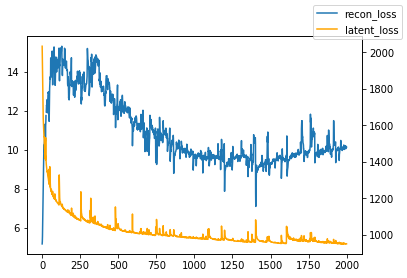

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

ax = plt.subplot(1, 1, 1)
ax.plot(losses.index, losses.recon_loss, label='recon_loss')

ax2 = ax.twinx()
ax2.plot(losses.index, losses.latent_loss, label='latent_loss', color='orange')
ax.figure.legend(loc='best')

In [59]:
# evaluate
p_z = ds.MultivariateNormalDiag(loc=[0.] * model.hidden_size, scale_diag=[1.] * model.hidden_size)

test_tensor = tf.constant(X_test.values, dtype='float32')
# mu, sigma = tf.split(model.encoder(test_tensor), 2, 1)
encoded = model.encoder(test_tensor)
mu, sigma = model.dense_mean(encoded), model.dense_std(encoded)

q_z = ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
test_pred = ds.kl_divergence(p_z, q_z)
# test_pred = tf.sigmoid(test_pred)

test_pred = test_pred.numpy()
test_pred = test_pred / (test_pred.max() - test_pred.min())

In [61]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, test_pred)

0.4640440094405109